In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.keras as keras


In [3]:
from tensorflow.keras.utils import Sequence

In [4]:
data = pd.read_csv(r"C:\Users\rejee\Desktop\Agitation - Copy.csv")
data

,Location,level,Observation,Behaviour
0,Kitchen,5,Withdrawn,Normal
1,Kitchen,3,"Vocal1, Withdrawn",Normal
2,Other,3,Withdrawn,Normal
3,Other,4,Withdrawn,Normal
4,Other,4,"Vocal2, Withdrawn",Normal
...,...,...,...,...
9979,Kitchen,1,Repetition;,Normal
9980,Kitchen,1,Repetition;,Normal
9981,Kitchen,1,Repetition;,Normal
9982,Kitchen,1,Repetition;,Normal


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['Observation'], data['Behaviour'], test_size=0.33, random_state=42)

In [6]:
label_dict = {'Normal':0, 'Agitation':1}
y_train = [label_dict[label] for label in y_train]
y_test = [label_dict[label] for label in y_test]


In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [8]:
# Load the pre-trained word2vec model
from gensim.models import Word2Vec
word2vec = Word2Vec.load("word2vec.model")

In [9]:
# Create the embedding matrix
embedding_matrix = np.zeros((max_words, 50))
for word, i in tok.word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = word2vec.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)



In [11]:
# Build the model
model = Sequential()
model.add(Embedding(max_words, 50, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
42/42 [==============================] - 12s 241ms/step - loss: 0.5191 - accuracy: 0.8299 - val_loss: 0.4330 - val_accuracy: 0.8468
Epoch 2/10
42/42 [==============================] - 9s 217ms/step - loss: 0.4584 - accuracy: 0.8299 - val_loss: 0.4285 - val_accuracy: 0.8468


In [13]:


# Evaluate the model
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
accr = model

In [14]:
test_sequences_matrix = np.array(test_sequences_matrix)
y_test = np.array(y_test)

In [15]:
from keras.models import Model

In [16]:
scores = model.evaluate(test_sequences_matrix, y_test)
print("Accuracy:", scores[1])

103/103 [==============================] - 3s 31ms/step - loss: 0.4666 - accuracy: 0.8237
Accuracy: 0.8236722350120544


In [17]:
# Make predictions on the test data
predictions = model.predict(test_sequences_matrix)

103/103 [==============================] - 4s 32ms/step


In [18]:
# Round the predictions to 0 or 1
predictions = [round(x[0]) for x in predictions]

# Calculate the accuracy
accuracy = sum([1 if predictions[i] == y_test[i] else 0 for i in range(len(predictions))]) / len(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8236722306525038


In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test, predictions, target_names = ['Normal','Agitation']))

              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90      2714
   Agitation       0.00      0.00      0.00       581

    accuracy                           0.82      3295
   macro avg       0.41      0.50      0.45      3295
weighted avg       0.68      0.82      0.74      3295



C:\Users\rejee\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rejee\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rejee\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


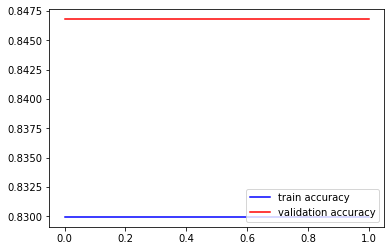

In [21]:
plt.plot(history.history['accuracy'],c='b',label='train accuracy')
plt.plot(history.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

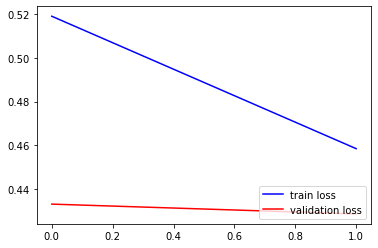

In [22]:
plt.plot(history.history['loss'],c='b',label='train loss')
plt.plot(history.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()